In [1]:
from data import *

In [3]:
# Generating Masks from Points

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import os


df = pd.read_csv("../hubmap-organ-segmentation/train.csv")
df['image_path'] = '../hubmap-organ-segmentation/train_images/'
df['image_path'] = df['image_path'].str.cat(df['id'].astype(str))
df['image_path'] = df['image_path'] + '.tiff'
df.head()


def helper(mask, img_shape):
  
    canvas = np.zeros(img_shape).T
    canvas[tuple(zip(*mask))] = 1.0

      # This is the Equivalent for loop of the above command for better understanding.
      # for pos in range(len(p_loc)):
      #   canvas[pos[0], pos[1]] = 1

    return canvas

def get_mask(rle_string, img_shape):
    rle = [int(i) for i in rle_string.split(' ')]
    pairs = list(zip(rle[0::2],rle[1::2]))

    p_loc = []

    for start, length in pairs:
        for p_pos in range(start, start + length):
            p_loc.append((p_pos % img_shape[1], p_pos // img_shape[0]))
  
    return helper(p_loc, img_shape)



def get_date(id:int, df: pd.DataFrame) -> tuple:
    """Get Important data
    
    Input:
        id: (int) id of the data
        df: (pandas.dataframe) Dataset 
    
    Output:
        tuple:
            int: Image id
            tuple: Image shape (height, width)
            image_path: Path of the image
            image: PIL Image object 
            polygons: Polygon points list
            mask: Mask of the image
        
    """
    get_vals = ["id",'img_height', 'img_width','image_path', 'rle']
    values = list()
    for i in get_vals:
        values.append(list(df[df["id"]==id][i].values)[0])

    # Getting image data
    img_id, img_height, img_width, image_path, rle = values
    img_shape = (img_width, img_height)
    image = Image.open(image_path)
    
    mask = get_mask(rle, img_shape)

    return (img_id, img_shape, image_path, image, mask)



masks_path = "../hubmap-organ-segmentation/train_masks/"
import matplotlib.pyplot as plt
for i in tqdm(range(len(df))):
    try:
        image_path = df['image_path'].iloc[i]
        idx = df['id'].iloc[i]
        mask_path = f"{masks_path}{image_path.rsplit('/',1)[-1]}"
        if not os.path.exists(mask_path):

            img_id, img_shape, image_path, image, mask = get_date(idx,df)
            print(image_path, mask_path)
    #         display([image, mask])
            plt.imsave(mask_path,mask)
    except:pass
        


100%|██████████| 351/351 [00:00<00:00, 5179.50it/s]


# Split train Val

In [4]:
import glob,os
images = glob.glob("../hubmap-organ-segmentation/train_images/*")
mask_images = "../hubmap-organ-segmentation/train_masks/"

val_masks = "../hubmap-organ-segmentation/val_masks/" 
val_images = "../hubmap-organ-segmentation/val_images/" 

val_imgaes = images[:50] 

for i in val_imgaes:
    mask_path = f"{mask_images}{i.rsplit('/',1)[-1]}"
    masks = glob.glob(mask_path)
    os.system(f"mv {mask_path} {val_masks}")
    os.system(f"mv {i} {val_images}") 
    



# data augmentation 

In deep learning tasks, a lot of data is need to train DNN model, when the dataset is not big enough, data augmentation should be applied.

keras.preprocessing.image.ImageDataGenerator is a data generator, which can feed the DNN with data like : (data,label), it can also do data augmentation at the same time.

It is very convenient for us to use keras.preprocessing.image.ImageDataGenerator to do data augmentation by implement image rotation, shift, rescale and so on... see [keras documentation](https://keras.io/preprocessing/image/) for detail.

For image segmentation tasks, the image and mask must be transformed **together!!**

## define your data generator

If you want to visualize your data augmentation result, set save_to_dir = your path

In [5]:
#if you don't want to do data augmentation, set data_gen_args as an empty dict.
#data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'../hubmap-organ-segmentation/','train_images','train_masks',data_gen_args,target_size = (3000,3000),save_to_dir = None)

## visualize your data augmentation result

/home/sohaib/anaconda3/envs/tf2_9/lib/python3.8/site-packages/keras/preprocessing/image.py:193: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 251 images belonging to 1 classes.
Found 251 images belonging to 1 classes.


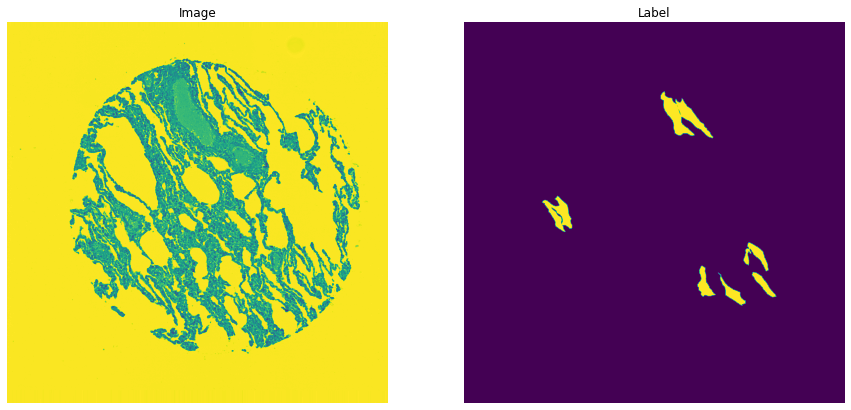

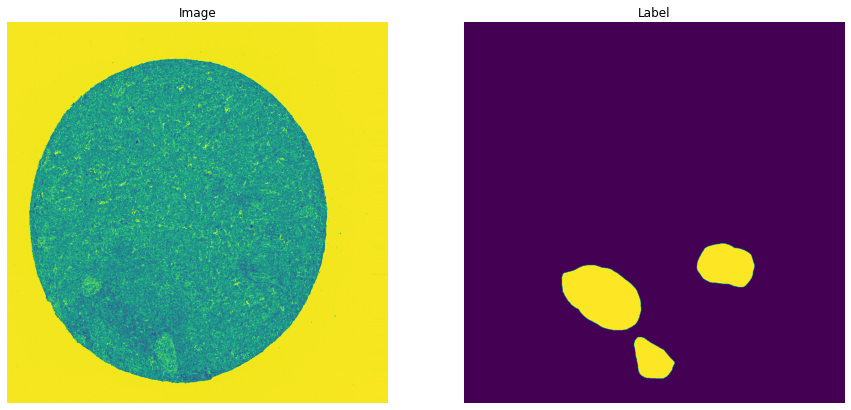

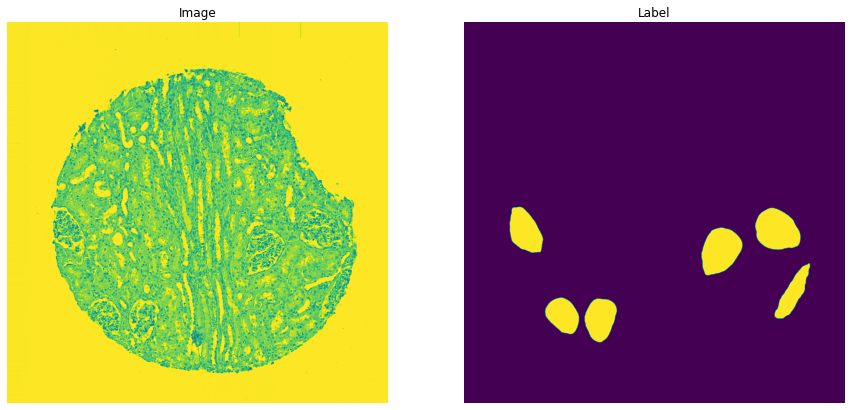

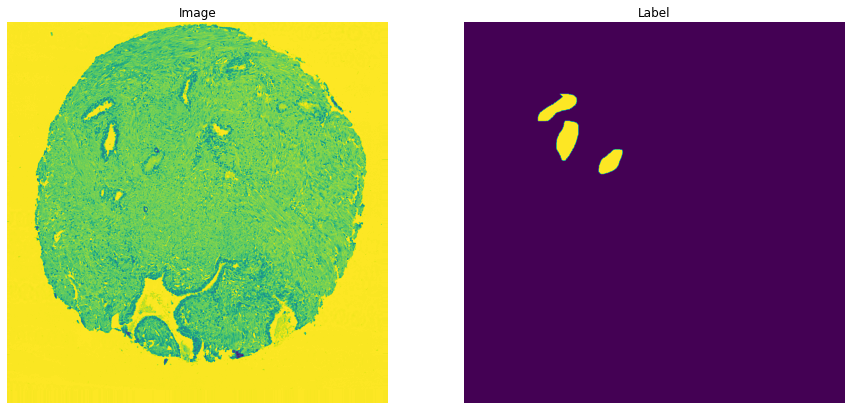

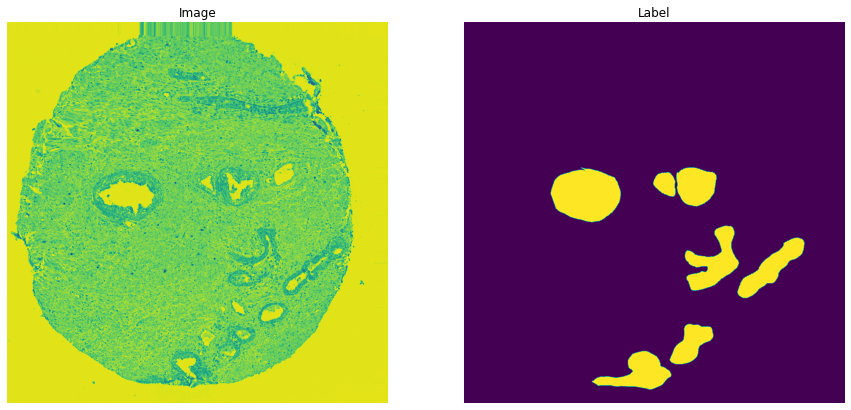

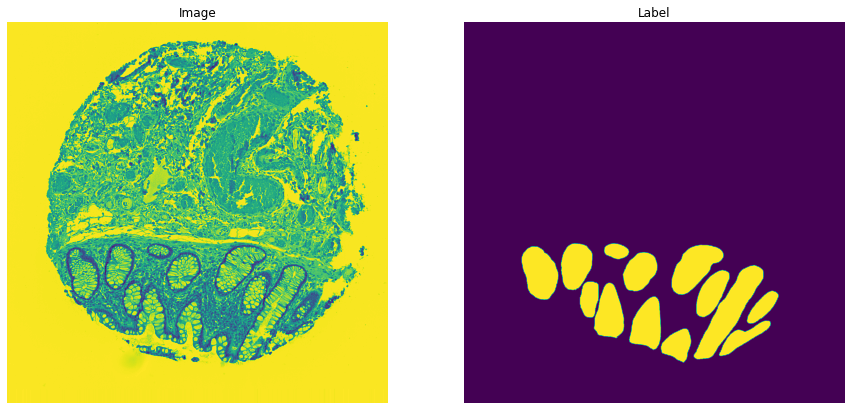

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
def display(display_list):
        '''
            
            Display Fucntion which display your image, groundtruth and prediction
            
            params: display_list : (list) List of images to display in a sequece
                                    e.g [image1, image2, image3] where image1, image2, image3 is numpy array
                                    
        '''
        
        # Title List to display on the top of the image
        gt_list = ["Image", "Label", "blend"]
        
        # Plot figure size
        plt.figure(figsize=(15, 15))
        
        # Appending all plot figs
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(gt_list[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        
        # Showing images
        plt.show()
        



num_batch = 5
for i,batch in enumerate(myGenerator):
    image, mask = batch
    display([image[0], mask[0]])
    
    if(i >= num_batch):
        break